# Long Short-Term Memory (LSTM) para Análisis de Series de Tiempo

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose

In [202]:
tf.random.set_seed(21562)

# Preparación de datos

Cargamos los datos

In [203]:
df = pd.read_csv('data/precios.csv', parse_dates=['Fecha'], index_col='Fecha')

In [204]:
df.head()

,Super,Regular,Diesel
Fecha,,,
2002-01-01,12.55,12.19,8.95
2002-02-01,12.29,11.90,8.66
2002-03-01,12.58,12.17,8.69
2002-04-01,14.11,13.71,9.38
2002-05-01,14.16,13.79,9.44


Visualización de los datos

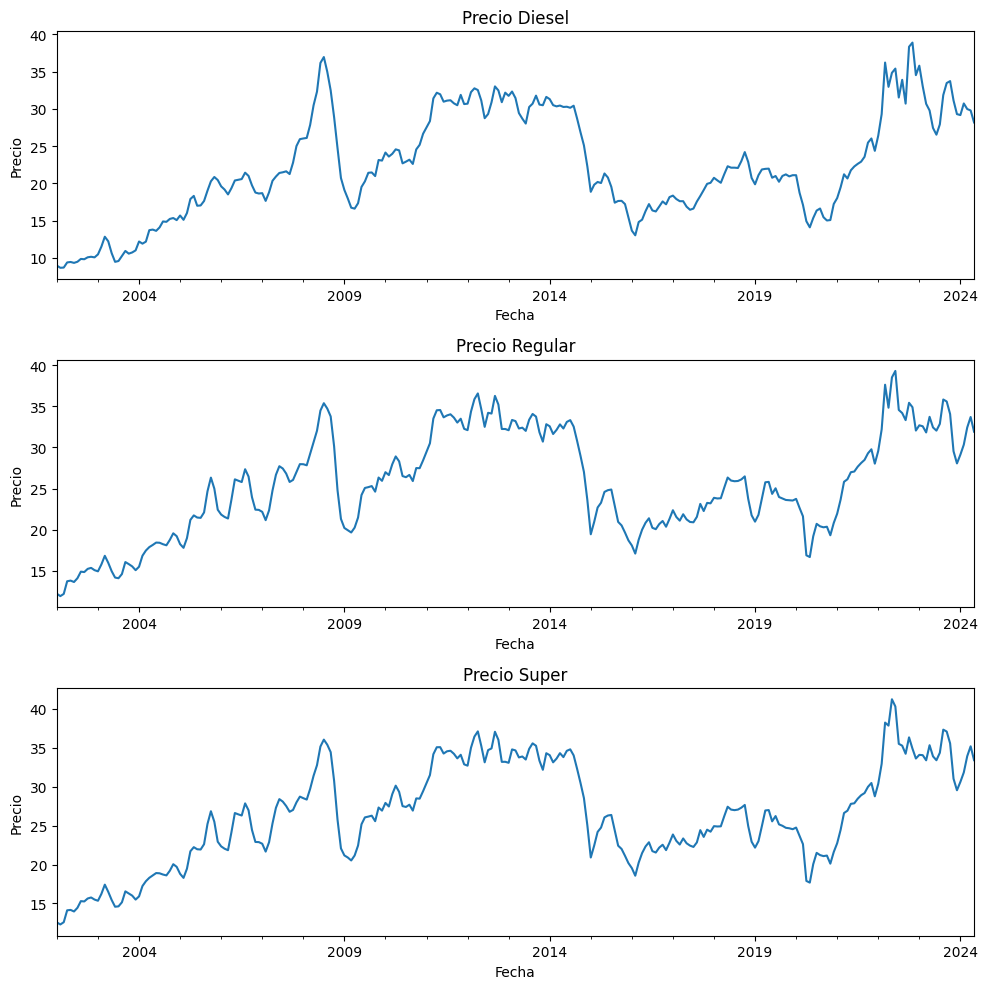

In [205]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

df['Diesel'].plot(
    ax=ax[0],
    title='Precio Diesel',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Regular'].plot(
    ax=ax[1],
    title='Precio Regular',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Super'].plot(
    ax=ax[2],
    title='Precio Super',
    xlabel='Fecha',
    ylabel='Precio'
)

plt.tight_layout()

plt.show()

Descompocisión de la serie de tiempo

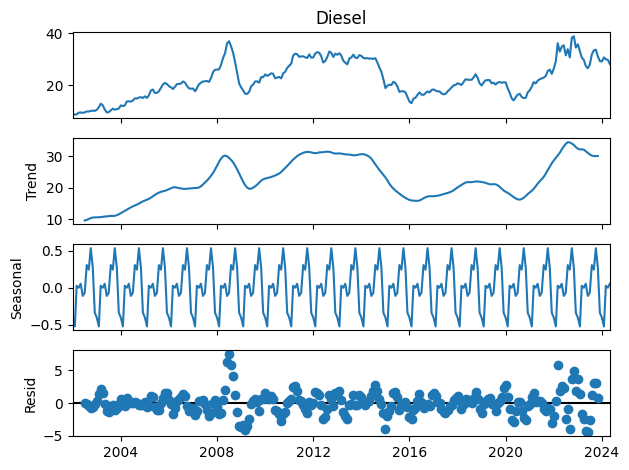

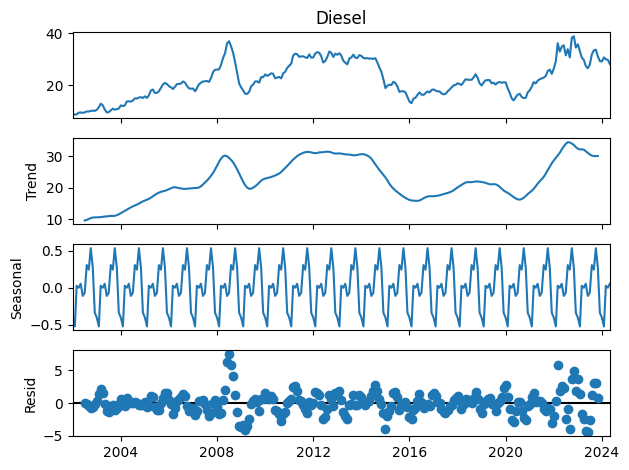

In [206]:
seasonal_decompose(df['Diesel'], model='additive', period=12).plot()

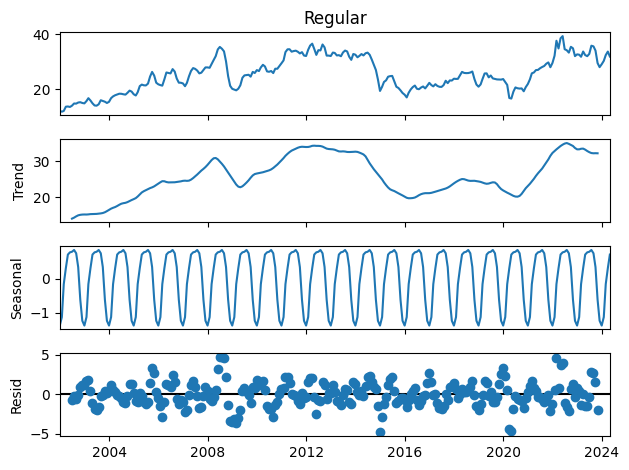

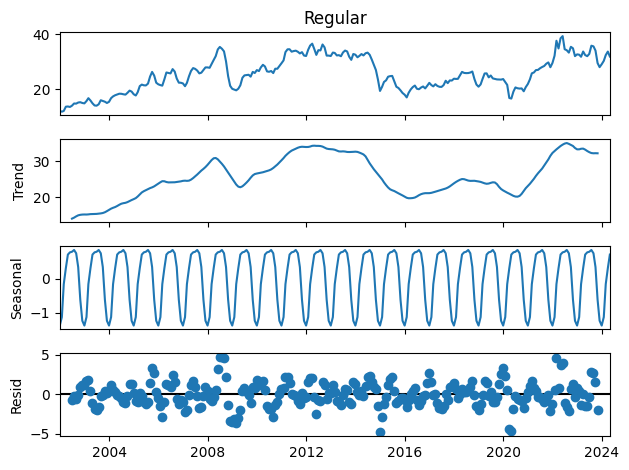

In [207]:
seasonal_decompose(df['Regular'], model='additive', period=12).plot()

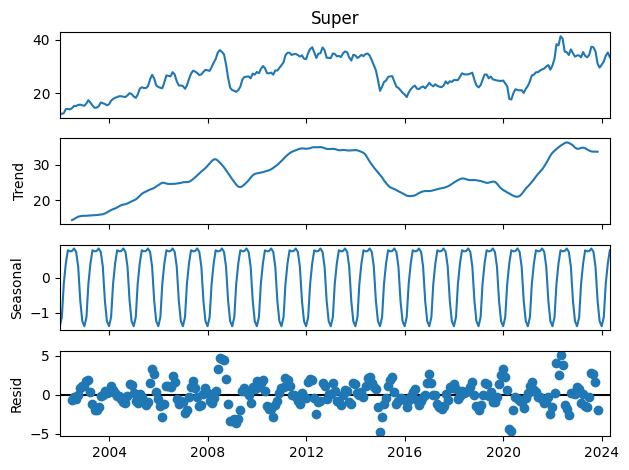

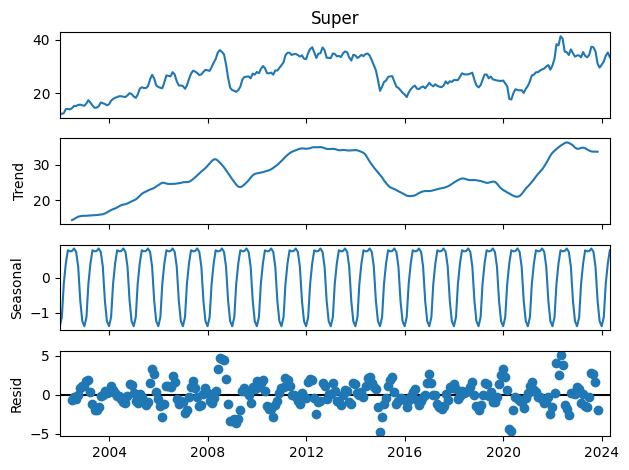

In [208]:
seasonal_decompose(df['Super'], model='additive', period=12).plot()

Diferenciación de la serie de tiempo

In [209]:
df['Diesel_diff'] = df['Diesel'].diff()

In [210]:
df['Regular_diff'] = df['Regular'].diff()

In [211]:
df['Super_diff'] = df['Super'].diff()

Eliminamos los valores nulos

In [212]:
df.dropna(inplace=True)

In [213]:
df.head()

,Super,Regular,Diesel,Diesel_diff,Regular_diff,Super_diff
Fecha,,,,,,
2002-02-01,12.29,11.90,8.66,-0.29,-0.29,-0.26
2002-03-01,12.58,12.17,8.69,0.03,0.27,0.29
2002-04-01,14.11,13.71,9.38,0.69,1.54,1.53
2002-05-01,14.16,13.79,9.44,0.06,0.08,0.05
2002-06-01,13.96,13.62,9.32,-0.12,-0.17,-0.20


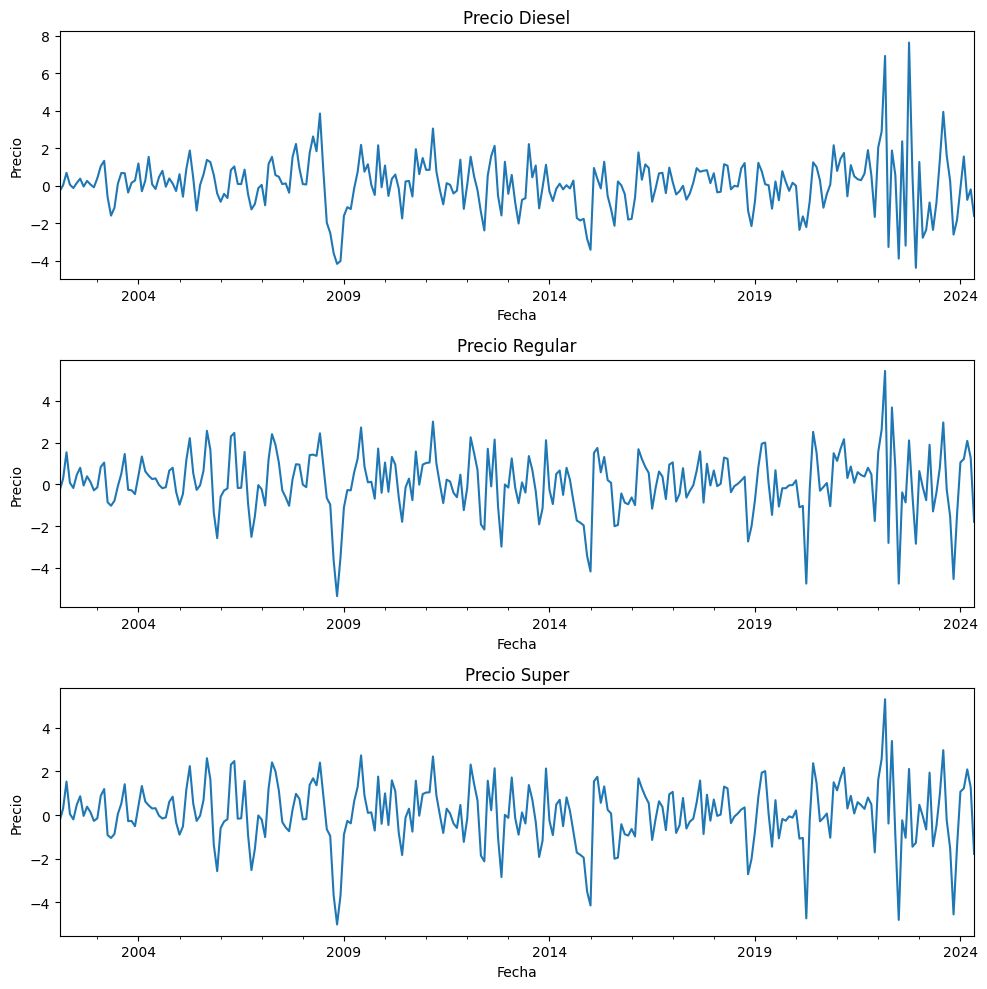

In [214]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

df['Diesel_diff'].plot(
    ax=ax[0],
    title='Precio Diesel',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Regular_diff'].plot(
    ax=ax[1],
    title='Precio Regular',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Super_diff'].plot(
    ax=ax[2],
    title='Precio Super',
    xlabel='Fecha',
    ylabel='Precio'
)

plt.tight_layout()

Normalización de los datos

In [215]:
scaler = MinMaxScaler(
    feature_range=(0, 1)
)

In [216]:
diesel_data = df['Diesel_diff'].values.reshape(-1, 1)
diesel_data = scaler.fit_transform(diesel_data)

In [217]:
regular_data = df['Regular_diff'].values.reshape(-1, 1)
regular_data = scaler.fit_transform(regular_data)

In [218]:
super_data = df['Super_diff'].values.reshape(-1, 1)
super_data = scaler.fit_transform(super_data)

Creación de secuencias

In [219]:
def create_sequences(data, seq_length=1, train_size=0.6, val_size=0.2, test_size=0.2):
    """
    Crea secuencias de datos "supervisados". Se crea una matriz bidimensional donde la dimennsión 0 es t-1 y la dimensión 1 es t.
    :param data: 
    :param seq_length: 
    :return: 
    """
    train_idx = int(len(data) * train_size)
    val_idx = int(len(data) * (train_size + val_size))

    train_data = data[:train_idx]
    val_data = data[train_idx:val_idx]
    test_data = data[val_idx:]

    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    for i in range(seq_length, len(train_data)):
        X_train.append(train_data[i - seq_length:i, 0])
        y_train.append(train_data[i, 0])

    for i in range(seq_length, len(val_data)):
        X_val.append(val_data[i - seq_length:i, 0])
        y_val.append(val_data[i, 0])

    for i in range(seq_length, len(test_data)):
        X_test.append(test_data[i - seq_length:i, 0])
        y_test.append(test_data[i, 0])
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [220]:
diesel_split = create_sequences(diesel_data)

X_train_diesel = diesel_split[0]
y_train_diesel = diesel_split[1]
X_val_diesel = diesel_split[2]
y_val_diesel = diesel_split[3]
X_test_diesel = diesel_split[4]
y_test_diesel = diesel_split[5]

In [221]:
regular_split = create_sequences(regular_data)

X_train_regular = regular_split[0]
y_train_regular = regular_split[1]
X_val_regular = regular_split[2]
y_val_regular = regular_split[3]
X_test_regular = regular_split[4]
y_test_regular = regular_split[5]

In [222]:
super_split = create_sequences(super_data)

X_train_super = super_split[0]
y_train_super = super_split[1]
X_val_super = super_split[2]
y_val_super = super_split[3]
X_test_super = super_split[4]
y_test_super = super_split[5]

## Modelo LSTM

### Versión 1
Se ha realizado un modelo donde la primera capa LSTM tiene 50 neuronas y retorna secuencias. La segunda capa LSTM tiene 50 neuronas y no retorna secuencias. Se ha añadido una capa densa de 25 neuronas y una capa de salida.

#### Diesel

In [223]:
model_diesel = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_diesel.shape[1], X_train_diesel.shape[2])),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

In [224]:
model_diesel.compile(optimizer='adam', loss='mean_squared_error')

In [225]:
model_diesel.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [226]:
X_test_diesel.shape

(53, 1, 1)

In [227]:
history_diesel = model_diesel.fit(
    X_train_diesel,
    y_train_diesel,
    epochs=100,
    batch_size=36,
    validation_data=(X_val_diesel, y_val_diesel),
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.1380 - val_loss: 0.0952
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0943 - val_loss: 0.0573
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0570 - val_loss: 0.0270
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0280 - val_loss: 0.0087
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0120 - val_loss: 0.0057
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - val_loss: 0.0095
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0123 - val_loss: 0.0062
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_loss: 0.0052
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - val_loss: 0.0053
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0099 - val_loss: 0.0053
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0098 - val_los

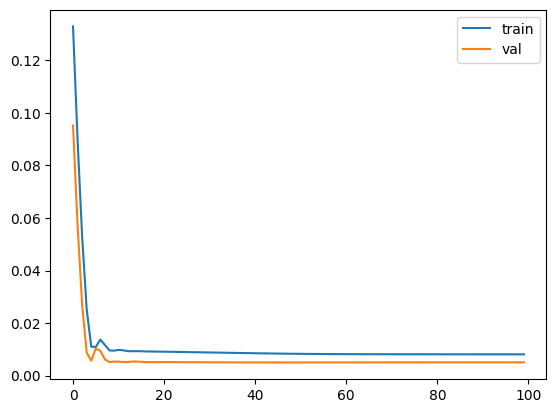

In [228]:
plt.plot(history_diesel.history['loss'], label='train')
plt.plot(history_diesel.history['val_loss'], label='val')
plt.legend()
plt.show()

In [229]:
y_pred_diesel = model_diesel.predict(X_test_diesel)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step


In [230]:
y_pred_diesel = scaler.inverse_transform(y_pred_diesel)

In [231]:
y_test_diesel_normal = scaler.inverse_transform(y_test_diesel.copy().reshape(-1, 1))

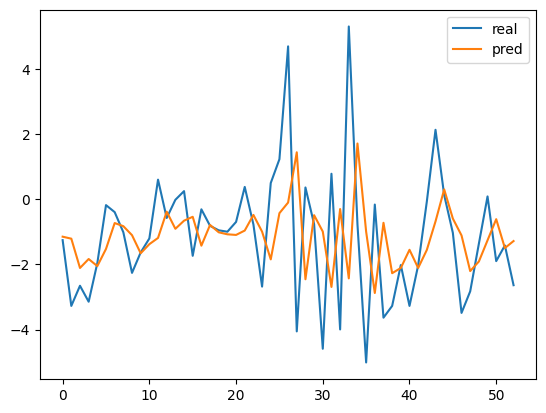

In [232]:
plt.plot(y_test_diesel_normal, label='real')
plt.plot(y_pred_diesel, label='pred')
plt.legend()
plt.show()

#### Regular

In [233]:
model_regular = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_regular.shape[1], X_train_regular.shape[2])),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

In [234]:
model_regular.compile(optimizer='adam', loss='mean_squared_error')

In [235]:
model_regular.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [236]:
history_regular = model_regular.fit(
    X_train_regular,
    y_train_regular,
    epochs=100,
    batch_size=36,
    validation_data=(X_val_regular, y_val_regular),
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.2467 - val_loss: 0.1904
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1886 - val_loss: 0.1360
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1339 - val_loss: 0.0855
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0835 - val_loss: 0.0427
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0421 - val_loss: 0.0149
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - val_loss: 0.0087
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0142 - val_loss: 0.0154
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0198 - val_loss: 0.0151
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0182 - val_loss: 0.0102
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0142 - val_loss: 0.0083
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0134 - val_loss: 0.0085
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0138 - val_lo

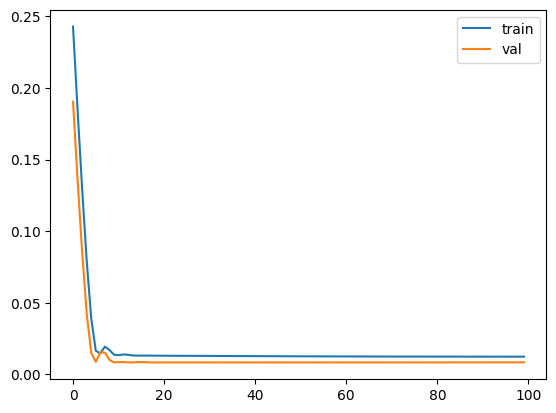

In [237]:
plt.plot(history_regular.history['loss'], label='train')
plt.plot(history_regular.history['val_loss'], label='val')
plt.legend()
plt.show()

In [238]:
y_pred_regular = model_regular.predict(X_test_regular)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step


In [239]:
y_pred_regular = scaler.inverse_transform(y_pred_regular)

In [240]:
y_test_regular_normal = scaler.inverse_transform(y_test_regular.copy().reshape(-1, 1))

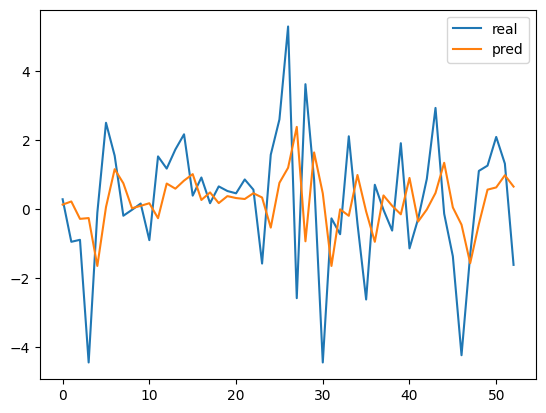

In [241]:
plt.plot(y_test_regular_normal, label='real')
plt.plot(y_pred_regular, label='pred')
plt.legend()
plt.show()

#### Super

In [242]:
model_super = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_super.shape[1], X_train_super.shape[2])),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

In [243]:
model_super.compile(optimizer='adam', loss='mean_squared_error')

In [244]:
model_super.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [245]:
history_super = model_super.fit(
    X_train_super,
    y_train_super,
    epochs=100,
    batch_size=36,
    validation_data=(X_val_super, y_val_super),
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.2418 - val_loss: 0.1896
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1915 - val_loss: 0.1411
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1420 - val_loss: 0.0940
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0942 - val_loss: 0.0518
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0524 - val_loss: 0.0209
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0235 - val_loss: 0.0091
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0196 - val_loss: 0.0170
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0203 - val_loss: 0.0122
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - val_loss: 0.0093
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146 - val_loss: 0.0092
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - val_lo

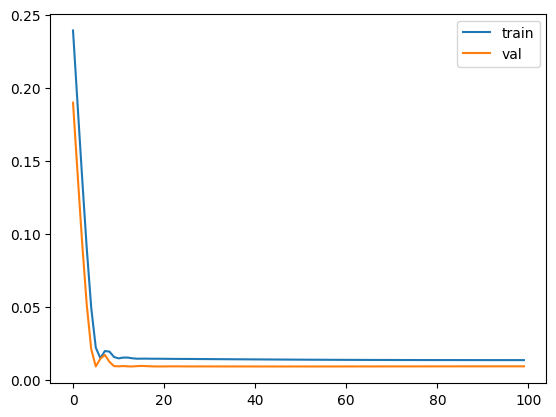

In [246]:
plt.plot(history_super.history['loss'], label='train')
plt.plot(history_super.history['val_loss'], label='val')
plt.legend()
plt.show()

In [247]:
y_pred_super = model_super.predict(X_test_super)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step


In [248]:
y_pred_super = scaler.inverse_transform(y_pred_super)

In [249]:
y_test_super_normal = scaler.inverse_transform(y_test_super.copy().reshape(-1, 1))

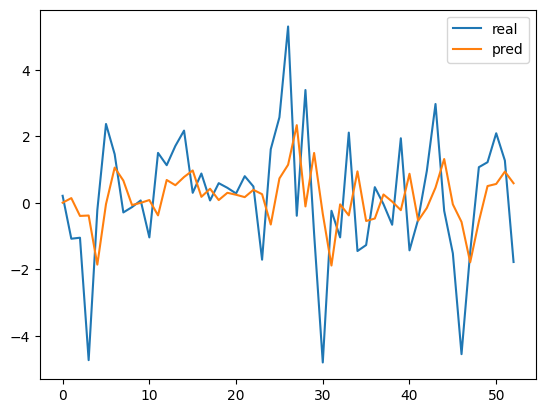

In [250]:
plt.plot(y_test_super_normal, label='real')
plt.plot(y_pred_super, label='pred')
plt.legend()
plt.show()

### Versión 2
Se ha realizado una LSTM de 50 neuronas que retorna secuencias, para luego hacer un dropout de 0.2. Procede a una capa LSTM bidireccional de 50 neuronas que no retorna secuencias. Se añade un dropout de 0.2 y una capa densa de 25 neuronas. Finalmente, se añade una capa de salida.

#### Diesel

In [251]:
model_diesel_v2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_diesel.shape[1], X_train_diesel.shape[2])),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=False)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [252]:
model_diesel_v2.compile(optimizer='adam', loss='mean_squared_error')

In [253]:
model_diesel_v2.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 1, 100)         │        20,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 100)            │        60,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,751 (327.15 KB)

 Trainable params: 83,751 (327.15 KB)

 Non-trainable params: 0 (0.00 B)

In [254]:
history_diesel_v2 = model_diesel_v2.fit(
    X_train_diesel,
    y_train_diesel,
    epochs=100,
    batch_size=36,
    validation_data=(X_val_diesel, y_val_diesel),
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - loss: 0.1427 - val_loss: 0.1156
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1182 - val_loss: 0.0899
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0916 - val_loss: 0.0630
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0636 - val_loss: 0.0362
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0366 - val_loss: 0.0140
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0160 - val_loss: 0.0050
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0125 - val_loss: 0.0102
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127 - val_loss: 0.0061
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_l

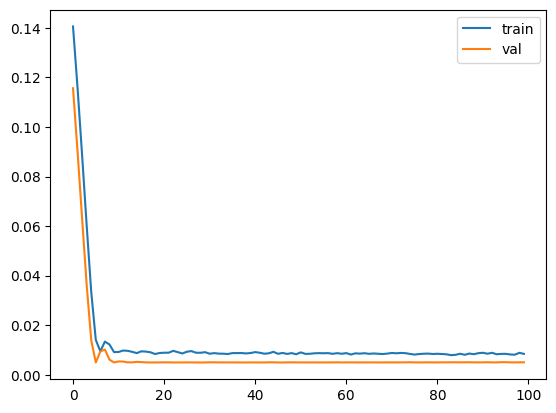

In [255]:
plt.plot(history_diesel_v2.history['loss'], label='train')
plt.plot(history_diesel_v2.history['val_loss'], label='val')
plt.legend()
plt.show()

In [256]:
y_pred_diesel_v2 = model_diesel_v2.predict(X_test_diesel)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 482ms/step


In [257]:
y_pred_diesel_v2 = scaler.inverse_transform(y_pred_diesel_v2)

In [258]:
y_test_diesel_normal = scaler.inverse_transform(y_test_diesel.copy().reshape(-1, 1))

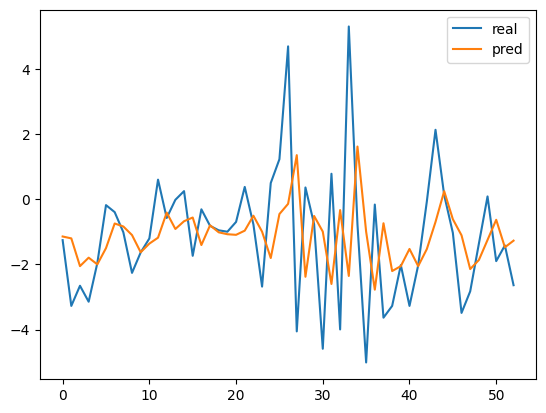

In [259]:
plt.plot(y_test_diesel_normal, label='real')
plt.plot(y_pred_diesel_v2, label='pred')
plt.legend()
plt.show()

#### Regular

In [260]:
model_regular_v2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_regular.shape[1], X_train_regular.shape[2])),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=False)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [261]:
model_regular_v2.compile(optimizer='adam', loss='mean_squared_error')

In [262]:
model_regular_v2.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_12                │ (None, 1, 100)         │        20,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 100)            │        60,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,751 (327.15 KB)

 Trainable params: 83,751 (327.15 KB)

 Non-trainable params: 0 (0.00 B)

In [263]:
history_regular_v2 = model_regular_v2.fit(
    X_train_regular,
    y_train_regular,
    epochs=100,
    batch_size=36,
    validation_data=(X_val_regular, y_val_regular),
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 0.2525 - val_loss: 0.2050
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2041 - val_loss: 0.1551
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1529 - val_loss: 0.1024
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0988 - val_loss: 0.0518
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0494 - val_loss: 0.0156
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0171 - val_loss: 0.0102
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0166 - val_loss: 0.0200
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0238 - val_loss: 0.0142
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0177 - val_loss: 0.0085
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0132 - val_loss: 0.0089
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143 - val_loss: 0.0094
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0151 - val_l

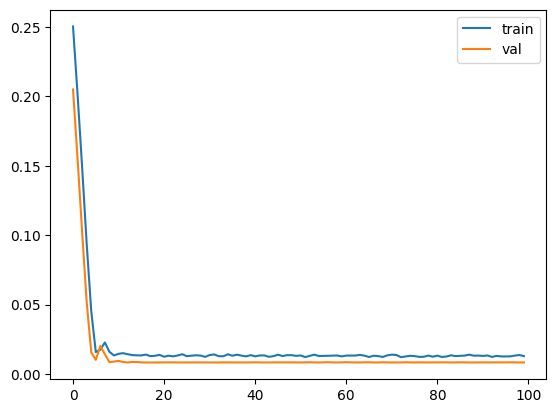

In [264]:
plt.plot(history_regular_v2.history['loss'], label='train')
plt.plot(history_regular_v2.history['val_loss'], label='val')
plt.legend()
plt.show()

In [265]:
y_pred_regular_v2 = model_regular_v2.predict(X_test_regular)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


In [266]:
y_pred_regular_v2 = scaler.inverse_transform(y_pred_regular_v2)

In [267]:
y_test_regular_normal = scaler.inverse_transform(y_test_regular.copy().reshape(-1, 1))

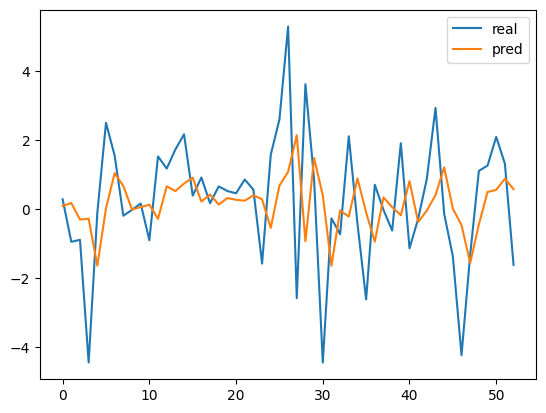

In [268]:
plt.plot(y_test_regular_normal, label='real')
plt.plot(y_pred_regular_v2, label='pred')
plt.legend()
plt.show()

#### Super

In [269]:
model_super_v2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_super.shape[1], X_train_super.shape[2])),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=False)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [270]:
model_super_v2.compile(optimizer='adam', loss='mean_squared_error')

In [271]:
model_super_v2.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_14                │ (None, 1, 100)         │        20,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 100)            │        60,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,751 (327.15 KB)

 Trainable params: 83,751 (327.15 KB)

 Non-trainable params: 0 (0.00 B)

In [272]:
history_super_v2 = model_super_v2.fit(
    X_train_super,
    y_train_super,
    epochs=100,
    batch_size=36,
    validation_data=(X_val_super, y_val_super),
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - loss: 0.2430 - val_loss: 0.1917
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1917 - val_loss: 0.1377
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1358 - val_loss: 0.0830
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0811 - val_loss: 0.0358
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0339 - val_loss: 0.0103
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0212 - val_loss: 0.0195
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0235 - val_loss: 0.0116
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0162 - val_loss: 0.0091
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0137 - val_loss: 0.0098
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0150 - val_loss: 0.0097
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0149 - val_l

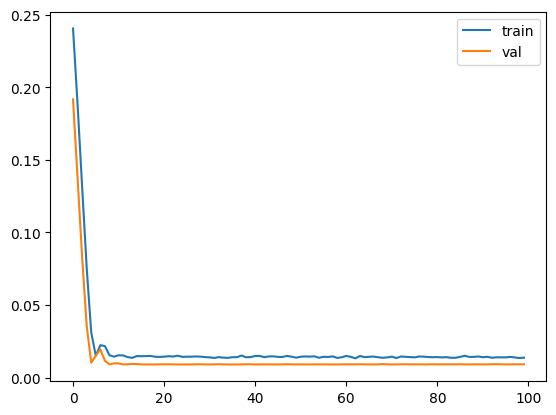

In [273]:
plt.plot(history_super_v2.history['loss'], label='train')
plt.plot(history_super_v2.history['val_loss'], label='val')
plt.legend()
plt.show()

In [274]:
y_pred_super_v2 = model_super_v2.predict(X_test_super)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


In [275]:
y_pred_super_v2 = scaler.inverse_transform(y_pred_super_v2)

In [276]:
y_test_super_normal = scaler.inverse_transform(y_test_super.copy().reshape(-1, 1))

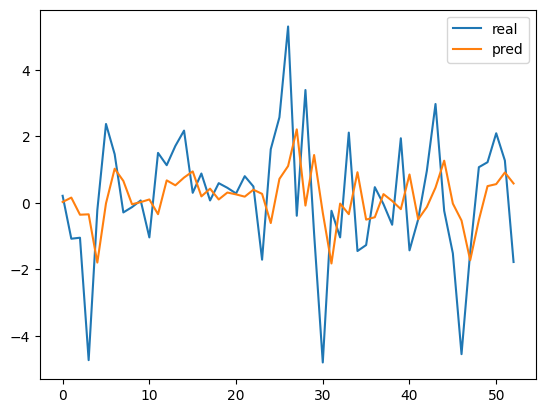

In [277]:
plt.plot(y_test_super_normal, label='real')
plt.plot(y_pred_super_v2, label='pred')
plt.legend()
plt.show()